<a href="https://colab.research.google.com/github/pratyaksh12/Image_Classification/blob/main/PyTorch_With_Costom_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing pytorch and device agnostic code

In [1]:
import torch
from torch import nn

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


##Get data

- ill be taking data from food 101 since i found that from pytorch dont judge me BUT since the amount of data is a bit too much ill be using the one that Bourke made :)

In [4]:
from pathlib import Path
import requests
import zipfile

#Setup path for the data folder

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

#if the image doesn't exist, download it and prepare it

if image_path.is_dir():
  print(f"{image_path} already exists skipping download")
else:
  print(f"{image_path} doesn't exist creating one...")
  image_path.mkdir(parents= True, exist_ok = True)


#download pizza steak and sushi data

with open(data_path / "pizza_steak_sushi.zip", 'wb') as f:

  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
  print(f"downloading pizza steak and sushi data ...")
  f.write(request.content)

with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
  print("unzipping the file")

  zip_ref.extractall(image_path)

data/pizza_steak_sushi doesn't exist creating one...
downloading pizza steak and sushi data ...
unzipping the file


##Analysing the data



In [5]:
import os

def walk_through_dir(dir_path):
  """Walks through dir path returning its content"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dir_path} .")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi .
There are 3 directories and 0 images in data/pizza_steak_sushi .
There are 0 directories and 75 images in data/pizza_steak_sushi .
There are 0 directories and 78 images in data/pizza_steak_sushi .
There are 0 directories and 72 images in data/pizza_steak_sushi .
There are 3 directories and 0 images in data/pizza_steak_sushi .
There are 0 directories and 19 images in data/pizza_steak_sushi .
There are 0 directories and 25 images in data/pizza_steak_sushi .
There are 0 directories and 31 images in data/pizza_steak_sushi .


In [7]:
#setting up training and test paths

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

##Visualising the image

1. get all the image paths
2. Pick a random image path
3. get the image class name `pathlib.Path.parent.stem`
4. since we're working with images, let's open the image with PIL
5. Show the image and meta data

image path = data/pizza_steak_sushi/train/pizza/2228322.jpg
image_class = pizza
image_height = 512
imge_width = 512


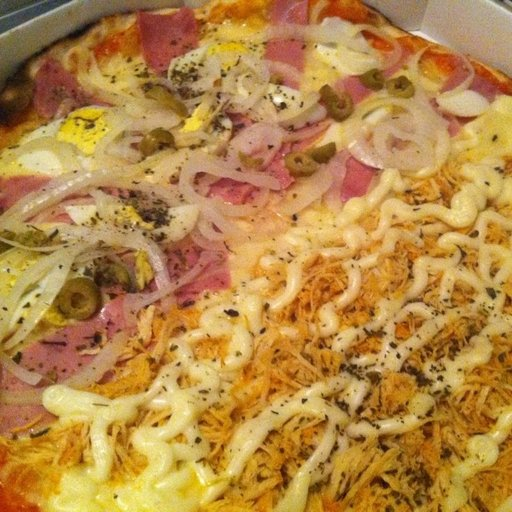

In [8]:
import random
from PIL import Image

# random.seed(42)

#get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list

#pick a random image path
random_image_path = random.choice(image_path_list)
random_image_path

#get the image class
image_class = random_image_path.parent.stem
image_class

#opening the image using PIL
img = Image.open(random_image_path)

#print some meta data
print(f"image path = {random_image_path}")
print(f"image_class = {image_class}")
print(f"image_height = {img.height}")
print(f"imge_width = {img.width}")
img

Text(0.5, 1.0, 'Image class = pizza, Image shape = (512, 512, 3), Image height = 512, Image Width = 512')

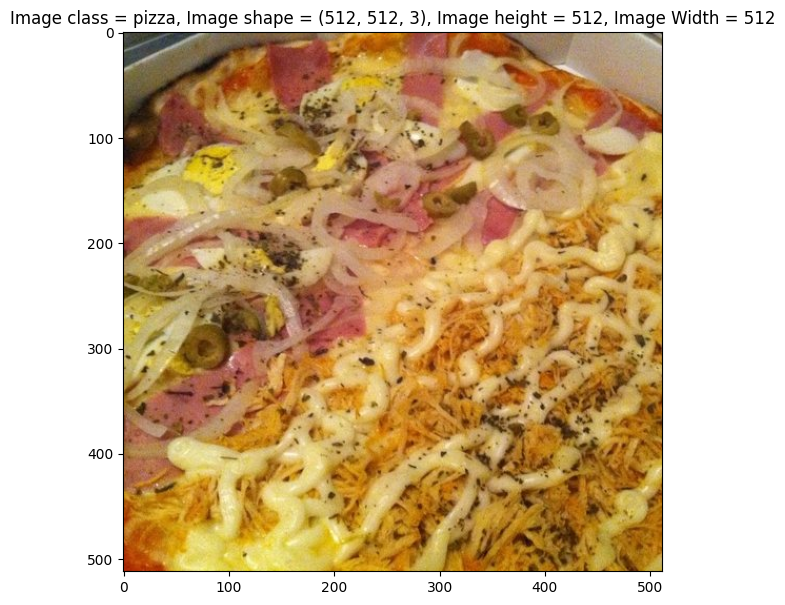

In [9]:
import numpy as np
import matplotlib.pyplot as plt

#turn image to an array
img_arr = np.asarray(img)

#plot the image
plt.figure(figsize= (10,7))

plt.imshow(img_arr)
plt.title(f"Image class = {image_class}, Image shape = {img_arr.shape}, Image height = {img.height}, Image Width = {img.width}")

array([[[ 90,  95,  73],
        [ 76,  81,  61],
        [ 70,  74,  57],
        ...,
        [105, 100,  94],
        [ 72,  69,  62],
        [ 54,  51,  44]],

       [[ 73,  78,  58],
        [ 73,  78,  58],
        [ 78,  82,  67],
        ...,
        [157, 153, 144],
        [133, 129, 120],
        [ 93,  90,  81]],

       [[ 69,  73,  56],
        [ 75,  79,  62],
        [ 83,  87,  73],
        ...,
        [165, 161, 150],
        [161, 157, 145],
        [149, 145, 133]],

       ...,

       [[173,  44,  12],
        [170,  41,   9],
        [167,  39,   4],
        ...,
        [195, 168,  63],
        [199, 172,  67],
        [204, 177,  72]],

       [[173,  43,  11],
        [173,  43,  11],
        [170,  40,   8],
        ...,
        [194, 166,  57],
        [195, 167,  58],
        [198, 170,  60]],

       [[169,  39,   7],
        [173,  43,  11],
        [174,  44,  12],
        ...,
        [188, 160,  50],
        [186, 156,  46],
        [187, 157,  45]]], dtype=uint8)
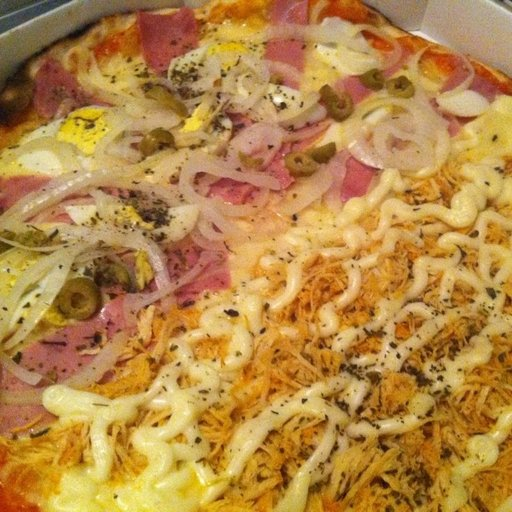

In [10]:
img_arr

##Transforming the data
before we can use our image data with pytorch
1. turn target data to target tensor
2. turn it into `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`


In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

##Transforming data with `torchvision.transforms`

- Turn the target data to tensor
- Turn it into a torch.utilss.data.Dataset and subsequently into a DataLoader from torch.utils.data.Dataloader

In [12]:
data_transform = transforms.Compose([
    #resize the images
    transforms.Resize(size = (64, 64)),
    #flip the images along horizintal axis
    transforms.RandomHorizontalFlip(p  = 0.5),
    #turn images to tensor
    transforms.ToTensor()
])

In [13]:
data_transform(img)

tensor([[[0.2824, 0.2627, 0.2627,  ..., 0.7255, 0.5765, 0.5255],
         [0.2902, 0.2980, 0.2980,  ..., 0.7137, 0.7333, 0.7020],
         [0.3020, 0.2784, 0.3216,  ..., 0.7059, 0.7098, 0.7255],
         ...,
         [0.6980, 0.7216, 0.7373,  ..., 0.6078, 0.6863, 0.7020],
         [0.6902, 0.7176, 0.7255,  ..., 0.6588, 0.7059, 0.7412],
         [0.6667, 0.7059, 0.7098,  ..., 0.6510, 0.7333, 0.7647]],

        [[0.2941, 0.2706, 0.2784,  ..., 0.7098, 0.5608, 0.4941],
         [0.3098, 0.3216, 0.3176,  ..., 0.6627, 0.7020, 0.6706],
         [0.3373, 0.3137, 0.3255,  ..., 0.6392, 0.6549, 0.6745],
         ...,
         [0.2627, 0.3255, 0.3882,  ..., 0.4000, 0.4588, 0.4627],
         [0.2235, 0.2784, 0.3176,  ..., 0.4510, 0.5098, 0.5882],
         [0.1765, 0.2353, 0.2549,  ..., 0.4588, 0.5922, 0.6667]],

        [[0.2627, 0.2235, 0.2235,  ..., 0.6314, 0.5020, 0.4314],
         [0.2784, 0.3020, 0.3098,  ..., 0.5765, 0.6353, 0.6000],
         [0.3020, 0.3137, 0.3216,  ..., 0.5412, 0.5569, 0.

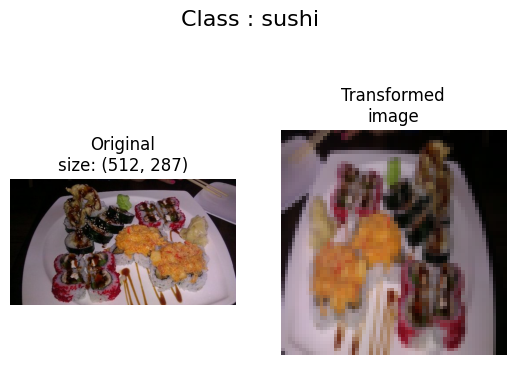

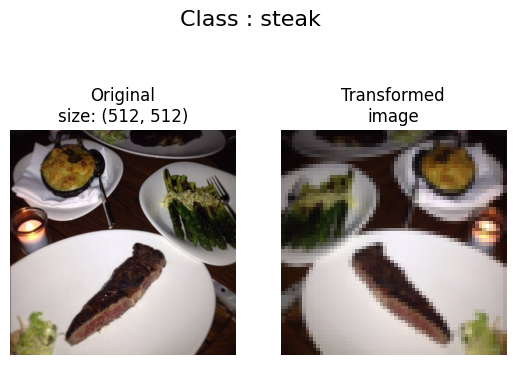

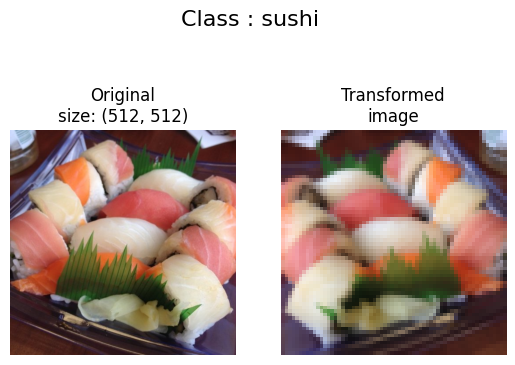

In [14]:
def plot_transformed_images(image_path, transform, n = 3, seed = 42):
  """selects random images from the path of random images and then plots the original vs the transformed version."""
  if seed:
    random.seed(42)

  random_image_paths = random.sample(image_path, k = n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows= 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nsize: {f.size}")
      ax[0].axis(False)

      #transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0)# we will need to change the shape so that matplotlib can access it [C, H, W] -> [H, W, C]

      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nimage")
      ax[1].axis("off")

      fig.suptitle(f"Class : {image_path.parent.stem}", fontsize = 16)
plot_transformed_images(image_path_list, data_transform, 3, None)

###1 Option 1: Loading image data using `ImageFolder`

- converting all the images to tensors and storing them
we can load images classificaion data using `torchvision.datasets.ImageFolder`

In [15]:
from  torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir, transform = data_transform, target_transform= None )
test_data = datasets.ImageFolder(root = test_dir, transform = data_transform, target_transform= None)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [16]:
class_names = train_data.classes

In [17]:
image, label = train_data[80]

(-0.5, 63.5, 63.5, -0.5)

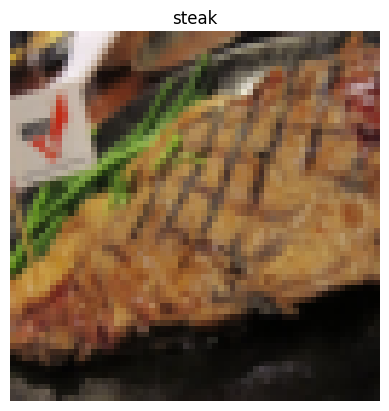

In [18]:
plt.imshow(image.permute(1,2,0)) # matplotlib cannot take in color channel first so change the permutation to [w, h, c]
plt.title(class_names[label])
plt.axis(False)

In [19]:
#Turn the data to data loader for mini batches
from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_dataloader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, num_workers= os.cpu_count() , shuffle = True)
test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, num_workers = os.cpu_count(), shuffle = False)



In [20]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [21]:
image, label = next(iter(train_dataloader))

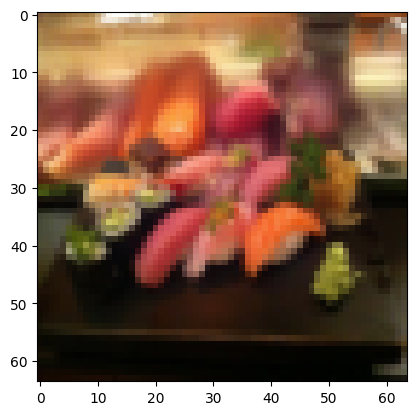

In [22]:
plt.imshow(image[0].permute(1,2,0))

## loading image data with a custom dataset
1. Want to be able to load images from the file
2. want to be able to get class names from the daatset
3. want to be able to get class dictionary from the dataset

- Pros
1. Can create a dataset out of almost anythin
2. Not limited to pytorch pre built dataset functions

- Cons
1. Almost out of anything doesn't mean it' ll work
2. Using a custom dataset means that there can be bugs, problems and performance issues


In [23]:
import os
import pathlib
import torch
from PIL import ImageChops
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [24]:
#instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#creating a helper function to create class names

we want function to:
1. Get class names using `os.scandir` to traverse a target directory (ideally the directory is in the standard image classification format)
2. Raise an error if the class names aren't found
3. turn the class names into a dict and a list and return them

In [25]:
#setup the target directory to load the data from

target_directory = train_dir
print(f"Target : {target_directory}")

#Get class names from the directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])


Target : data/pizza_steak_sushi/train


In [26]:
list(class_names)

['pizza', 'steak', 'sushi']

In [27]:
class_names_found

['pizza', 'steak', 'sushi']

In [28]:
def find_classes(directory : str) -> Tuple[List[str], Dict[str, int]]:
  #returnong the classes of the data
  classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

  #maping the classes
  class_to_idx = {class_name : i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [29]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#Creatinga costom dataset by subclassing `Dataset` imiating `ImageFolder`

To create our own costom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get the data from) as well as a transform if we'd like to transform our data
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of classes
  * class_to_idx - a dict of target class mapped to integer labels
4. create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getItem()__` method to return a given sample when passed an index
  

In [30]:
#write a costum dataset
from torch.utils.data import Dataset

#subclass torch.utils.data.dataset

class ImageFolderCustom(Dataset):
  #initialise the custom dataset
  def __init__(self, target_dir : str, transform = None):
    #create class attributes
    self.paths = list(pathlib.Path(target_dir).rglob("*.jpg"))
    #setup transform
    self.transform = transform
    #create classes and class_to_idx
    self.classes, self.class_to_idx = find_classes(target_dir)


  #4 create a function to load images
  def load_images(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_images(index)
    class_name = self.paths[index].parent.name
    class_name_idx = self.class_to_idx[class_name]

    #transform if necessary
    if self.transform:
      return self.transform(img), class_name_idx
    else:
      return img, class_name_idx



In [31]:

train_data_custom = ImageFolderCustom(train_dir, transform = data_transform)
test_data_custom = ImageFolderCustom(test_dir, transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [32]:
img,label = train_data[0]

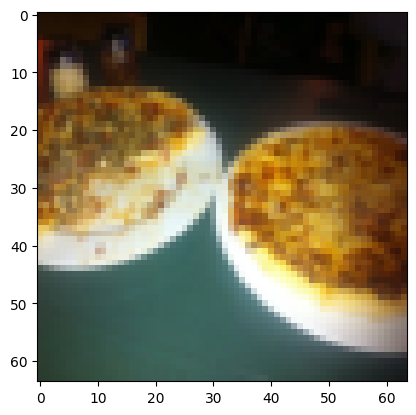

In [33]:
plt.imshow(img.permute(1,2,0))

In [34]:
train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

#function to disaplay random dataset
1. Take in a dataset and display a number of parameters such as class names and how many images to visualise.
2. To prevent the display from getting out of hand, lets cap the number of images to see at 10.
3. set random seed for reproducibility
4. get a list of random sample indexes from the target dataset
5. setup a matplotlib plt.plot
6. loop throug the random sampler and plot them
7. we need to show the dimension of the images (they should match up with the matplotlib dimension)



In [35]:
# create a function to take in a dataset

def display_random_images(dataset : torch.utils.data.Dataset, classes : List[str] = None, n : int = 10, display_shape : bool = True, seed : int = None):
  #adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"val of n is greater than 10, setting n to 10 and display_shape to False")
  #set the random_seed for reproducibility
  if seed:
    random.seed(seed)

  #get random smaple indexes
  indexes = [random.randint(1, len(dataset) - 1) for _ in range(n)]
  #indexes = random.choices(range(len(dataset)), k = n)

  #setup plot

  plt.figure(figsize = (18,4) )


  #loop through rando imges and plot them using matplotlib
  for i, target_sample in enumerate(indexes):
    targ_image, targ_label = dataset[target_sample]

    #adjust tensor dimension form plotting
    targ_image_adjust = targ_image.permute(1,2,0)

    #plot adjusted samples
    plt.subplot(1, n, i + 1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)

    if classes:
      title = f"Class : {dataset.classes[targ_label]}"
      if display_shape:
        title += f"\nShape = {targ_image_adjust.size()}"

    plt.title(title)



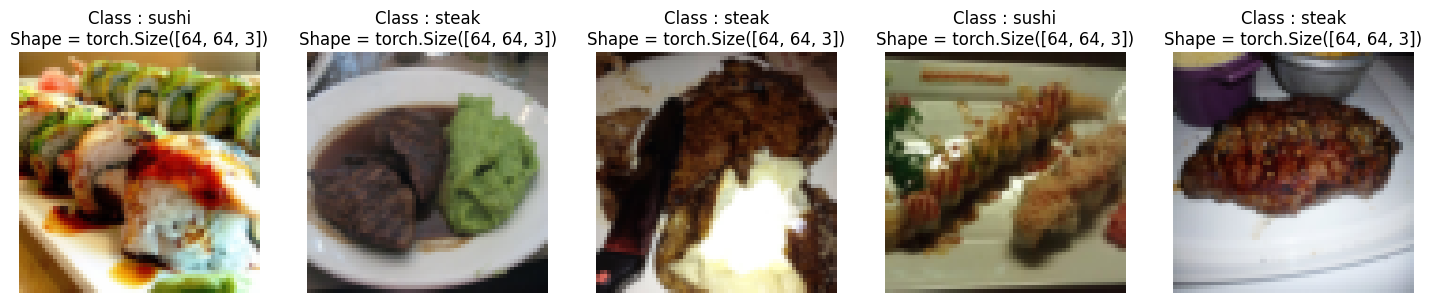

In [36]:
display_random_images(dataset = train_data_custom, classes = train_data_custom.classes, n = 5, display_shape = True, seed = 42)

In [37]:
##Turning custom dataset to dataloader

from torch.utils.data import DataLoader
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset = train_data_custom, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, pin_memory= True)
test_dataloader_custom = DataLoader(dataset = test_data_custom, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS, pin_memory= True)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a299a68d910>,
 <torch.utils.data.dataloader.DataLoader at 0x7a2a640f7ad0>)

In [38]:
len(train_dataloader_custom), len(test_dataloader_custom)

(8, 3)

In [39]:
#Get image and label from dataloader

img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, len(label_custom)

(torch.Size([32, 3, 64, 64]), 32)

In [40]:
print("Hello world")

Hello world


#Other forms of transforms(data augmentation)

Data augmentation is the process of artificially adding diversity to the training data

In case of image data, this means applying various image transformation to the training images

basically bringing in diversity for learning of model



In [41]:
#Trivial augment

from torchvision import transforms

train_transform = transforms.Compose([transforms.Resize(size = (224,224)), transforms.TrivialAugmentWide(num_magnitude_bins = 31), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize(size = ((224,224))), transforms.ToTensor()])

In [42]:
image_path

PosixPath('data/pizza_steak_sushi')

In [43]:
image_path = list(image_path.glob("*/*/*.jpg"))
image_path

[PosixPath('data/pizza_steak_sushi/train/steak/3727491.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/339891.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/234626.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2129685.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/922752.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2614189.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/176508.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1621763.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3577618.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/100135.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2222018.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/75537.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2013535.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1839481.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/355715.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2648423.jpg'),
 PosixPath('data

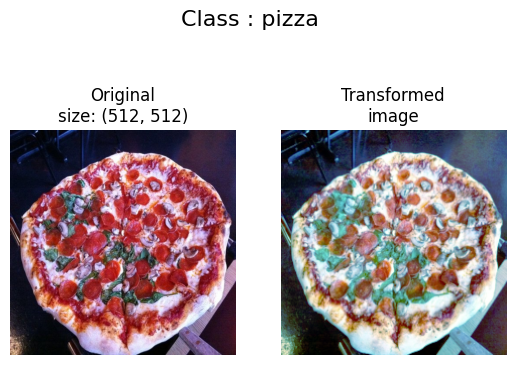

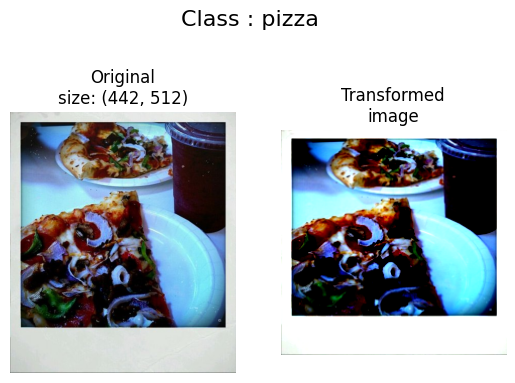

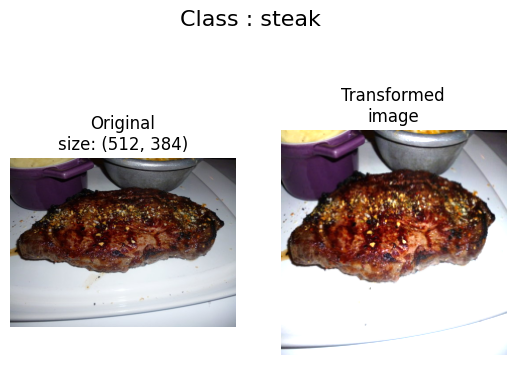

In [44]:
plot_transformed_images(
    image_path = image_path_list,
    transform = train_transform,
    n = 3,
    seed = None

)

#model 0 TinyVGG without data augmentation



In [45]:
#simple transform
import torchvision

simple_transform = transforms.Compose([transforms.Resize(size = (64, 64)), transforms.ToTensor()])

train_data = torchvision.datasets.ImageFolder(root = train_dir, transform = simple_transform,target_transform = None)
test_data = torchvision.datasets.ImageFolder(root = test_dir, transform = simple_transform, target_transform = None)

#set data to dataloaders

import os
from torch.utils.data import dataloader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset= train_data, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, pin_memory = True)
test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS, pin_memory = True)


In [46]:
#create Tiny VGG model class
from torch import nn

class TinyVGG(nn.Module):

  def __init__(self, input_shape, hidden_shape, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels = input_shape,
            out_channels = hidden_shape,
            kernel_size = 3,
            stride = 1,
            padding = 0),
        nn.ReLU(),
        nn.Conv2d(
            in_channels = hidden_shape,
            out_channels = hidden_shape,
            kernel_size = 3,
            stride = 1,
            padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(
            in_channels = hidden_shape,
            out_channels = hidden_shape,
            kernel_size = 3,
            stride = 1,
            padding = 0),
        nn.ReLU(),
        nn.Conv2d(
            in_channels = hidden_shape,
            out_channels = hidden_shape,
            kernel_size = 3,
            stride = 1,
            padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.decision_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features =hidden_shape * 169, out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.decision_layer(x)
    return x

In [47]:
print("Hello world")

Hello world


In [48]:
torch.manual_seed(42)
model_0 = TinyVGG(3, 10, 3).to(device)

In [49]:
next(model_0.parameters())

Parameter containing:
tensor([[[[ 0.1471,  0.1597, -0.0451],
          [ 0.1768, -0.0422,  0.0388],
          [-0.0937,  0.1130,  0.1697]],

         [[-0.1412,  0.1673,  0.0360],
          [ 0.1422,  0.0261,  0.0928],
          [-0.0272,  0.1484,  0.0284]],

         [[-0.0898,  0.0491, -0.0887],
          [-0.0226, -0.0782,  0.1277],
          [-0.1519, -0.0887, -0.0543]]],


        [[[-0.1157,  0.0182, -0.1901],
          [ 0.1738, -0.1635,  0.1486],
          [ 0.0320, -0.0625,  0.1189]],

         [[ 0.0300,  0.1555,  0.0210],
          [-0.0607,  0.0517, -0.0522],
          [ 0.0810,  0.1718,  0.1112]],

         [[-0.0841,  0.1111,  0.0344],
          [ 0.0977, -0.1173, -0.1905],
          [-0.0744, -0.1476,  0.1579]]],


        [[[ 0.0554,  0.0797,  0.0609],
          [-0.0033,  0.1506, -0.1367],
          [ 0.0121, -0.1314,  0.0593]],

         [[-0.0663,  0.0590, -0.0401],
          [ 0.1596, -0.1141, -0.1148],
          [-0.1148,  0.1731,  0.0641]],

         [[ 0.1852, -0

In [50]:
dummy = torch.rand(size = (32,3,64,64))
model_0.eval()
with torch.inference_mode():
  y_pred = model_0(dummy)

In [51]:
y_pred.argmax(dim = 1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [52]:
### `torchinfo` for getting an idea about the model

In [53]:
!pip install torchinfo

In [54]:
from torchinfo import summary

summary(model_0, input_size = [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [55]:
def train_step(model : torch.nn.Module, dataloader : torch.utils.data.DataLoader, loss_fn : torch.nn, optimizer : torch.optim.Optimizer, device = device):

  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    #forward pass
    y_pred = model(X)

    #Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    #zero gradding
    optimizer.zero_grad()

    #backward pass
    loss.backward()

    #gradient descent
    optimizer.step()

    #Calculate accuracy metrics
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)

    train_acc += (y_pred_class == y).sum().item()/len(y)

  #Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)

  return train_acc, train_loss




In [56]:
def test_step(model : torch.nn.Module, dataloader : torch.utils.data.DataLoader, loss_fn : torch.nn, device = device):


  test_acc, test_loss = 0,0
  model.eval()
  with torch.inference_mode():
    for X_test, y_test in (dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)

      #Forwrad pass
      y_test_pred = model(X_test)

      #Calculate loss
      test_loss += loss_fn(y_test_pred, y_test).item()

      #Accuracy update
      y_test_label = torch.argmax(y_test_pred, dim = 1)
      test_acc += (y_test_label == y_test).sum().item()/len(y_test)

  #Adjust the metrics so as to get the average fo loss and acc

    test_acc /= len(dataloader)
    test_loss /= len(dataloader)

    return test_acc, test_loss

In [57]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

def loop_through(model : torch.nn.Module, train_dataloader : torch.utils.data.DataLoader, test_dataloader : torch.utils.data.DataLoader, loss_fn : torch.nn, optimizer : torch.optim.Optimizer,epochs : int = 5, device = device):


  results = {
      'train_loss' : [],
      'train_acc' : [],
      'test_loss' : [],
      'test_acc' : []
  }
  start_time = timer()
  for epoch in tqdm(range(epochs)):

    train_acc, train_loss = train_step(model, train_dataloader, loss_fn, optimizer)
    test_acc, test_loss = test_step(model, test_dataloader, loss_fn)


    print(f"Train_loss = {train_loss :.4f}, Train_acc = {train_acc :.4f}, test_loss = {test_loss :.4f}, test_acc = {test_acc :.4f}")

    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

  end_time = timer()


  print(f"\n total_time for training and testing = {(end_time - start_time):.4f} seconds")

  return results





In [58]:
#train and evaluation of model_0
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 7

#recreating tiny VGG
model_0 = TinyVGG(input_shape= 3, hidden_shape = 10, output_shape = len(train_data.classes)).to(device)

#setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr = 0.001)

In [59]:
model_0_result = result = loop_through(model_0, train_dataloader, test_dataloader, loss_fn, optimizer, 30, device)

  0%|          | 0/30 [00:00<?, ?it/s]

Train_loss = 1.1063, Train_acc = 0.3047, test_loss = 1.0983, test_acc = 0.3011
Train_loss = 1.0998, Train_acc = 0.3281, test_loss = 1.0697, test_acc = 0.5417
Train_loss = 1.0869, Train_acc = 0.4883, test_loss = 1.0808, test_acc = 0.4924
Train_loss = 1.0842, Train_acc = 0.3984, test_loss = 1.0608, test_acc = 0.5833
Train_loss = 1.0662, Train_acc = 0.4141, test_loss = 1.0654, test_acc = 0.5644
Train_loss = 1.0305, Train_acc = 0.4336, test_loss = 1.0139, test_acc = 0.5426
Train_loss = 0.9854, Train_acc = 0.4219, test_loss = 0.9323, test_acc = 0.5938
Train_loss = 0.9663, Train_acc = 0.5781, test_loss = 0.9986, test_acc = 0.4432
Train_loss = 0.9238, Train_acc = 0.5977, test_loss = 1.0669, test_acc = 0.3324
Train_loss = 0.9969, Train_acc = 0.4648, test_loss = 1.0632, test_acc = 0.4044
Train_loss = 0.8697, Train_acc = 0.5195, test_loss = 0.9761, test_acc = 0.4830
Train_loss = 0.9243, Train_acc = 0.4609, test_loss = 0.9351, test_acc = 0.5445
Train_loss = 0.7839, Train_acc = 0.6328, test_loss =

In [60]:
model_0_result

{'train_loss': [1.106319084763527,
  1.0998057276010513,
  1.0868544578552246,
  1.0842333287000656,
  1.0662163645029068,
  1.0305046811699867,
  0.9854388535022736,
  0.9663243293762207,
  0.9237585514783859,
  0.9968554675579071,
  0.8697074726223946,
  0.9242511913180351,
  0.7838825695216656,
  0.9043351262807846,
  0.7889668345451355,
  0.7488975711166859,
  0.7730635069310665,
  0.7477861270308495,
  0.7746242582798004,
  0.7755993604660034,
  0.7839249894022942,
  0.7888880670070648,
  0.7334330417215824,
  0.8690939769148827,
  0.6534039881080389,
  0.7042508721351624,
  0.6319012260064483,
  0.6576803475618362,
  0.6021412936970592,
  0.7660123705863953],
 'train_acc': [0.3046875,
  0.328125,
  0.48828125,
  0.3984375,
  0.4140625,
  0.43359375,
  0.421875,
  0.578125,
  0.59765625,
  0.46484375,
  0.51953125,
  0.4609375,
  0.6328125,
  0.5234375,
  0.6953125,
  0.6796875,
  0.69921875,
  0.66015625,
  0.70703125,
  0.63671875,
  0.61328125,
  0.6015625,
  0.6484375,
  0.574

#plot the loss curve
- a loss cure is the way to track the loss of a model overtime(epochs)


In [61]:
def plot_loss_acc(results : Dict[str , List[float]]):

  loss = results['train_loss']
  test_loss = results['test_loss']

  accuracy = results['train_acc']
  accuracy_test = results['test_acc']


  epochs = list(range(len(results['train_acc'])))
  print(f"{len(epochs)}")

  plt.figure(figsize = (16,8))

  #plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label = 'train_loss')
  plt.plot(epochs, test_loss, label = 'test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label = 'train_accuracy')
  plt.plot(epochs, accuracy_test, label = 'test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.legend()




30


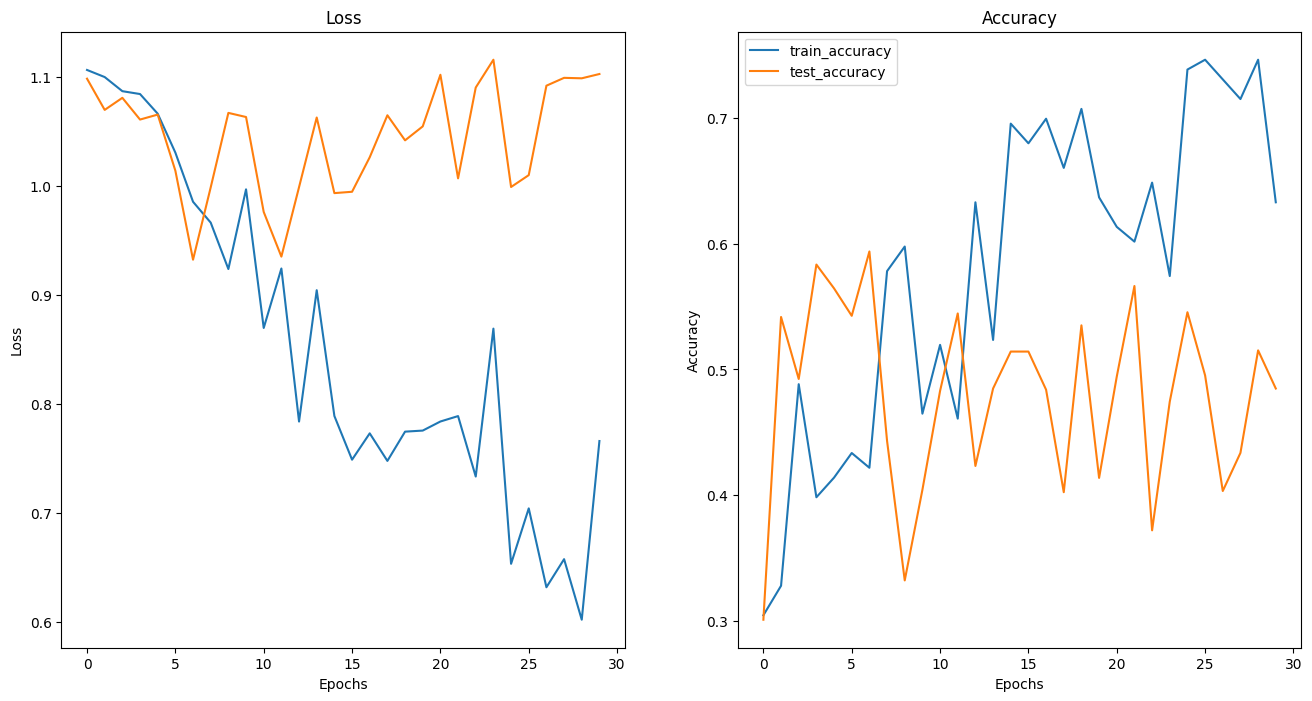

In [62]:
plot_loss_acc(model_0_result)

In [63]:
print("hello world")

hello world


#what does an ideal loss curve look like?

- a helpful way to troubleshoot the model

#Tiny VGG with data augmrntation

In [64]:
#transform with data augmentation

from torchvision import transforms

data_transform = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

simple_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])



#turn data to `datasets` and then `DataLoaders`

In [65]:
train_data = ImageFolderCustom(train_dir, transform = data_transform)
test_data = ImageFolderCustom(test_dir, transform = simple_transform)

In [66]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_data, BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)
train_dataloader = DataLoader(test_data, BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)

In [67]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a29986d5550>,
 <torch.utils.data.dataloader.DataLoader at 0x7a29997f50d0>)

In [68]:
model_1 = TinyVGG(3, 16, len(train_data.classes)).to(device)



In [69]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr = 0.001)

In [101]:
model_1_result = loop_through(model_1, train_dataloader, test_dataloader, loss_fn, optimizer, 30, device)

  0%|          | 0/30 [00:00<?, ?it/s]

Train_loss = 0.6706, Train_acc = 0.7188, test_loss = 0.6389, test_acc = 0.7292
Train_loss = 0.6409, Train_acc = 0.7292, test_loss = 0.6097, test_acc = 0.7604
Train_loss = 0.6090, Train_acc = 0.7708, test_loss = 0.5800, test_acc = 0.7917
Train_loss = 0.5752, Train_acc = 0.8021, test_loss = 0.5491, test_acc = 0.8229
Train_loss = 0.5394, Train_acc = 0.8333, test_loss = 0.5153, test_acc = 0.8438
Train_loss = 0.5019, Train_acc = 0.8438, test_loss = 0.4791, test_acc = 0.8542
Train_loss = 0.4623, Train_acc = 0.8646, test_loss = 0.4395, test_acc = 0.8750
Train_loss = 0.4199, Train_acc = 0.8750, test_loss = 0.3959, test_acc = 0.8854
Train_loss = 0.3750, Train_acc = 0.8750, test_loss = 0.3491, test_acc = 0.8958
Train_loss = 0.3286, Train_acc = 0.9167, test_loss = 0.3018, test_acc = 0.9271
Train_loss = 0.2835, Train_acc = 0.9271, test_loss = 0.2557, test_acc = 0.9375
Train_loss = 0.2386, Train_acc = 0.9375, test_loss = 0.2116, test_acc = 0.9479
Train_loss = 0.1943, Train_acc = 0.9479, test_loss =

30


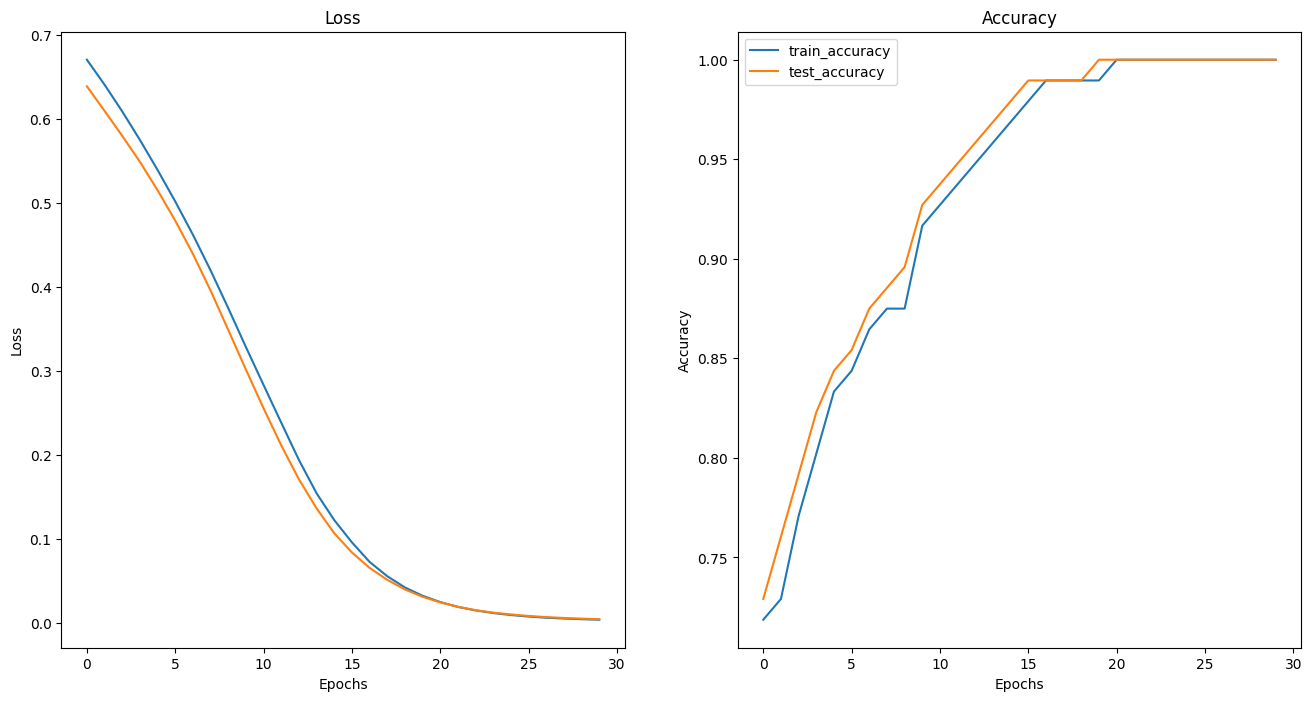

In [102]:
plot_loss_acc(model_1_result)

In [103]:
model_1_result

{'train_loss': [0.670582781235377,
  0.640859067440033,
  0.6089954376220703,
  0.5751518110434214,
  0.5393722007671992,
  0.5019201437632242,
  0.46231357753276825,
  0.4199240207672119,
  0.37496355672677356,
  0.3286036675175031,
  0.2834559033314387,
  0.23858781407276788,
  0.19430078069368997,
  0.15457618484894434,
  0.12269542117913564,
  0.0962060218056043,
  0.07297101803123951,
  0.055906604044139385,
  0.04255694678674141,
  0.032629079495867096,
  0.025147357024252415,
  0.01941726931060354,
  0.015230933669954538,
  0.012087908340618014,
  0.009714616384978095,
  0.007906399512042602,
  0.006552592928831776,
  0.005547289387322962,
  0.004774203621006261,
  0.004158015692761789],
 'train_acc': [0.71875,
  0.7291666666666666,
  0.7708333333333334,
  0.8020833333333334,
  0.8333333333333334,
  0.84375,
  0.8645833333333334,
  0.875,
  0.875,
  0.9166666666666666,
  0.9270833333333334,
  0.9375,
  0.9479166666666666,
  0.9583333333333334,
  0.96875,
  0.9791666666666666,
  

In [104]:
print("Hello world")

Hello world


In [105]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_result)
model_1_df = pd.DataFrame(model_1_result)

Text(0.5, 1.0, 'model_1 performance(accuracy)')

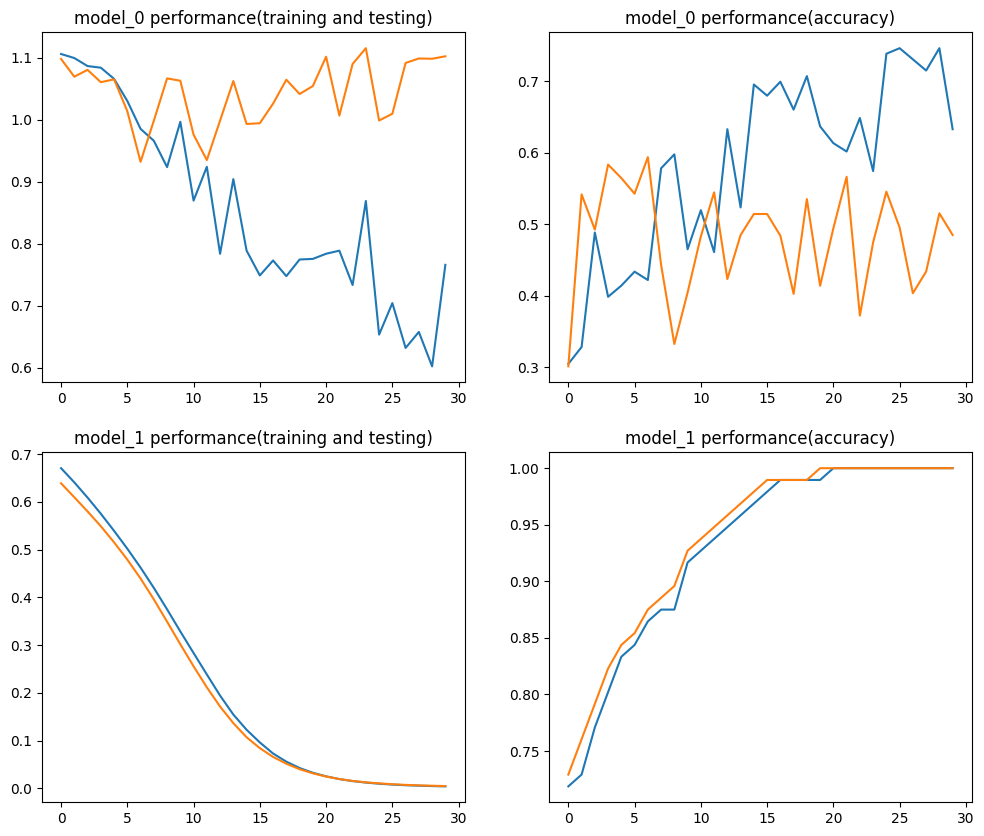

In [106]:
plt.figure(figsize = (12,10))
plt.subplot(2,2,1)
plt.plot(range(30), model_0_df["train_loss"], label = 'training loss')
plt.plot(range(30), model_0_df["test_loss"], label = 'testing loss')
plt.title('model_0 performance(training and testing)')

plt.subplot(2,2,2)
plt.plot(range(30), model_0_df["train_acc"], label = 'training acc')
plt.plot(range(30), model_0_df["test_acc"], label = 'testing acc')
plt.title('model_0 performance(accuracy)')

plt.subplot(2,2,3)
plt.plot(range(30), model_1_df["train_loss"], label = 'training loss')
plt.plot(range(30), model_1_df["test_loss"], label = 'testing loss')
plt.title('model_1 performance(training and testing)')

plt.subplot(2,2,4)
plt.plot(range(30), model_1_df["train_acc"], label = 'training acc')
plt.plot(range(30), model_1_df["test_acc"], label = 'testing acc')
plt.title('model_1 performance(accuracy)')




In [107]:
import requests

custom_image_path = data_path / 'pizza-dad.jpeg'

if not Path(custom_image_path).is_file():
  with open(custom_image_path, 'wb') as f:
    print('downloading file')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg')

    f.write(request.content)


else:
  print('File already exists')

File already exists


In [108]:
import torchvision

custom_image = torchvision.io.read_image(custom_image_path)

In [109]:
custom_image

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

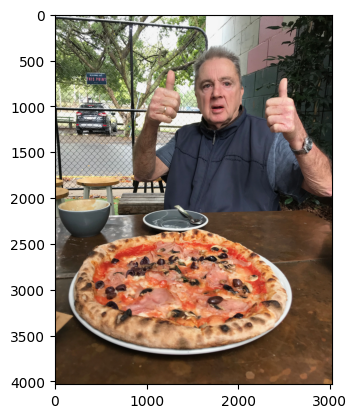

In [110]:
plt.imshow(custom_image.permute(1,2,0))

In [111]:
custom_image = torchvision.io.read_image(custom_image_path).type(torch.float)/255

In [112]:
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [113]:
data_transform = torchvision.transforms.Compose([transforms.Resize(size = (64,64))])

In [114]:
custom_image_transformed = data_transform(custom_image)

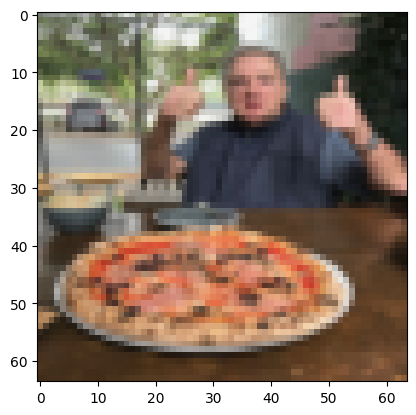

In [115]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [116]:
model_1.eval()
with torch.inference_mode():
  y_pred = model_1(custom_image_transformed.unsqueeze(0))

In [117]:
train_data.classes[torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)]

'pizza'